MINC 2500 Tutorial : take a pre-trained network as a feature extractor and train a classifier on it

THALES DMS France, 2019, Atelier ALLOHA du 15/01/2019

Import lib

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import applications
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.utils import to_categorical
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

/home/user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Database

In [2]:
train_data_dir = '/home/user/privatedata/MINC2500/minc-2500/train'
validation_data_dir = '/home/user/privatedata/MINC2500/minc-2500/test'
# 1001 training samples for each of the 23 classes
nb_train_samples = 1001*23
# 1499 validation samples for each of the 23 classes
nb_validation_samples = 1499*23

Images dimensions

In [3]:
img_width, img_height = 150, 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Training parameters

In [4]:
epochs = 10
batch_size = 32
top_model_weights_path = 'bottleneck_fc_model.h5'

Function for computing VGG16 features of the database images

In [5]:
def save_bottlebeck_features():
    
    # VGG16 network without fully-connected layers
    input_tensor = Input(shape=input_shape)
    model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Compute and save VGG16 features of the training database images
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, len(generator))
    bottleneck_features_train = bottleneck_features_train[:nb_train_samples]
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    # Compute and save VGG16 features of the test database images
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, len(generator))
    bottleneck_features_validation = bottleneck_features_validation[:nb_validation_samples]
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Function for training a dense neural network on computed VGG16 features of the database images

In [6]:
def train_top_model_nn():
    
    # Load VGG16 features of the training database images and associated labels
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * int(nb_train_samples / 23) + [1] * int(nb_train_samples / 23) 
        + [2] * int(nb_train_samples / 23) + [3] * int(nb_train_samples / 23)
        + [4] * int(nb_train_samples / 23) + [5] * int(nb_train_samples / 23)
        + [6] * int(nb_train_samples / 23) + [7] * int(nb_train_samples / 23)
        + [8] * int(nb_train_samples / 23) + [9] * int(nb_train_samples / 23)
        + [10] * int(nb_train_samples / 23) + [11] * int(nb_train_samples / 23)
        + [12] * int(nb_train_samples / 23) + [13] * int(nb_train_samples / 23)
        + [14] * int(nb_train_samples / 23) + [15] * int(nb_train_samples / 23)
        + [16] * int(nb_train_samples / 23) + [17] * int(nb_train_samples / 23)
        + [18] * int(nb_train_samples / 23) + [19] * int(nb_train_samples / 23)
        + [20] * int(nb_train_samples / 23) + [21] * int(nb_train_samples / 23)
        + [22] * int(nb_train_samples / 23))
    train_labels = to_categorical(train_labels)
    
    # Load VGG16 features of the test database images and associated labels
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 23) + [1] * int(nb_validation_samples / 23) 
        + [2] * int(nb_validation_samples / 23) + [3] * int(nb_validation_samples / 23)
        + [4] * int(nb_validation_samples / 23) + [5] * int(nb_validation_samples / 23)
        + [6] * int(nb_validation_samples / 23) + [7] * int(nb_validation_samples / 23)
        + [8] * int(nb_validation_samples / 23) + [9] * int(nb_validation_samples / 23)
        + [10] * int(nb_validation_samples / 23) + [11] * int(nb_validation_samples / 23)
        + [12] * int(nb_validation_samples / 23) + [13] * int(nb_validation_samples / 23)
        + [14] * int(nb_validation_samples / 23) + [15] * int(nb_validation_samples / 23)
        + [16] * int(nb_validation_samples / 23) + [17] * int(nb_validation_samples / 23)
        + [18] * int(nb_validation_samples / 23) + [19] * int(nb_validation_samples / 23)
        + [20] * int(nb_validation_samples / 23) + [21] * int(nb_validation_samples / 23)
        + [22] * int(nb_validation_samples / 23))
    validation_labels = to_categorical(validation_labels)

    # Neural Network
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(23, activation='softmax'))

    # Compiler
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # Training
    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    
    # Plot
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Save Network weights
    model.save_weights(top_model_weights_path)

Function for training a SVM on computed VGG16 features of the database images

In [11]:
def train_top_model_SVM():
    
    # Load VGG16 features of the training database images and associated labels
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_data = np.reshape(train_data,(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*train_data.shape[3]))
    train_labels = np.array(
        [0] * int(nb_train_samples / 23) + [1] * int(nb_train_samples / 23) 
        + [2] * int(nb_train_samples / 23) + [3] * int(nb_train_samples / 23)
        + [4] * int(nb_train_samples / 23) + [5] * int(nb_train_samples / 23)
        + [6] * int(nb_train_samples / 23) + [7] * int(nb_train_samples / 23)
        + [8] * int(nb_train_samples / 23) + [9] * int(nb_train_samples / 23)
        + [10] * int(nb_train_samples / 23) + [11] * int(nb_train_samples / 23)
        + [12] * int(nb_train_samples / 23) + [13] * int(nb_train_samples / 23)
        + [14] * int(nb_train_samples / 23) + [15] * int(nb_train_samples / 23)
        + [16] * int(nb_train_samples / 23) + [17] * int(nb_train_samples / 23)
        + [18] * int(nb_train_samples / 23) + [19] * int(nb_train_samples / 23)
        + [20] * int(nb_train_samples / 23) + [21] * int(nb_train_samples / 23)
        + [22] * int(nb_train_samples / 23))
    
    # Load VGG16 features of the test database images and associated labels
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_data = np.reshape(validation_data,(validation_data.shape[0], validation_data.shape[1]*validation_data.shape[2]*validation_data.shape[3]))
    validation_labels = np.array(
        [0] * int(nb_validation_samples / 23) + [1] * int(nb_validation_samples / 23) 
        + [2] * int(nb_validation_samples / 23) + [3] * int(nb_validation_samples / 23)
        + [4] * int(nb_validation_samples / 23) + [5] * int(nb_validation_samples / 23)
        + [6] * int(nb_validation_samples / 23) + [7] * int(nb_validation_samples / 23)
        + [8] * int(nb_validation_samples / 23) + [9] * int(nb_validation_samples / 23)
        + [10] * int(nb_validation_samples / 23) + [11] * int(nb_validation_samples / 23)
        + [12] * int(nb_validation_samples / 23) + [13] * int(nb_validation_samples / 23)
        + [14] * int(nb_validation_samples / 23) + [15] * int(nb_validation_samples / 23)
        + [16] * int(nb_validation_samples / 23) + [17] * int(nb_validation_samples / 23)
        + [18] * int(nb_validation_samples / 23) + [19] * int(nb_validation_samples / 23)
        + [20] * int(nb_validation_samples / 23) + [21] * int(nb_validation_samples / 23)
        + [22] * int(nb_validation_samples / 23))
    
    # Brute force approach : train multiple SVM with various parameter settings
    C_test = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
    gamma_test = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    acc_max = 0
    c0 = 0.000001
    g0 = 0.00000001
    for c in C_test:
        for g in gamma_test:
            svc = SVC(kernel='rbf', C=c, gamma=g)
            svc.fit(train_data, train_labels)
            restrain_tmp = svc.score(train_data, train_labels)
            res_tmp = svc.score(validation_data, validation_labels)
            print(["Precision SVM courante :"+" acc = "+str(100*restrain_tmp)+" acc_val = "+str(100*res_tmp)+" C = "+str(c)+" gamma = "+str(g)])
            if (100.0*res_tmp>acc_max):
                c0 = c
                g0 = g
                acc_max = 100.0*res_tmp
                
    
    svc = SVC(kernel='rbf', C=c0, gamma=g0)
    svc.fit(train_data, train_labels)
    score = svc.score(validation_data, validation_labels)
    print(["Precision SVM maximale : "+str(100.0*score)])

Compute VGG16 features of the database images

In [8]:
#save_bottlebeck_features()

Train dense neural network on computed VGG16 features of the database images

Train on 23023 samples, validate on 34477 samples
Epoch 1/10
23023/23023 [==============================] - 6s 243us/step - loss: 9.2815 - acc: 0.3665 - val_loss: 7.2640 - val_acc: 0.5023
Epoch 2/10
23023/23023 [==============================] - 5s 214us/step - loss: 7.0853 - acc: 0.5121 - val_loss: 6.1203 - val_acc: 0.5806
Epoch 3/10
23023/23023 [==============================] - 5s 214us/step - loss: 6.5716 - acc: 0.5579 - val_loss: 5.7933 - val_acc: 0.6069
Epoch 4/10
23023/23023 [==============================] - 5s 218us/step - loss: 6.2338 - acc: 0.5826 - val_loss: 5.8715 - val_acc: 0.6088
Epoch 5/10
23023/23023 [==============================] - 5s 217us/step - loss: 6.0536 - acc: 0.5959 - val_loss: 5.6820 - val_acc: 0.6226
Epoch 6/10
23023/23023 [==============================] - 5s 216us/step - loss: 5.7978 - acc: 0.6174 - val_loss: 5.6689 - val_acc: 0.6254
Epoch 7/10
23023/23023 [==============================] - 5s 218us/step - loss: 5.6570 - acc: 0.6273 - val_loss: 5.7640 - 

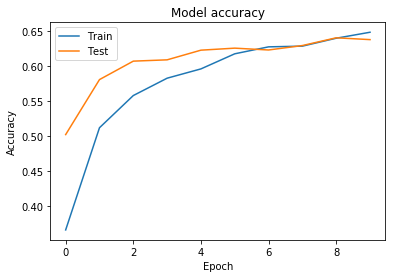

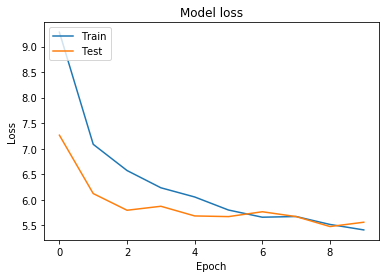

In [9]:
train_top_model_nn()

Train a SVM on computed VGG16 features of the database images

In [ ]:
train_top_model_SVM()